# 1. Install necessary packages

In [1]:
!pip install torchsampler
!pip install torchmetrics
!pip install split-folders

#  2. Import required libraries

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
from tqdm.autonotebook import tqdm, trange
import time
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix, classification_report
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data.sampler import BatchSampler
import pandas as pd
import random
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, LeakyReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py widgetsnbextension

/tmp/ipykernel_30/1163429827.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Installing /opt/conda/lib/python3.10/site-packages/widgetsnbextension/static -> jupyter-js-widgets
Making directory: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/
Copying: /opt/conda/lib/python3.10/site-packages/widgetsnbextension/static/extension.js -> /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js
Copying: /opt/conda/lib/python3.10/site-packages/widgetsnbextension/static/extension.js.map -> /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.map
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --py
    


# 3. Data Pre-processing

In [4]:
import splitfolders

# Split the dataset into train, test, and val folders
splitfolders.ratio('/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment', output="data1", seed=1337, ratio=(.7, 0.2, 0.1))

# Define the paths to train, test, and val folders
train_folder = "data1/train"
test_folder = "data1/test"
val_folder = "data1/val"


Copying files: 3076 files [00:28, 109.36 files/s]


**Data Augmentation**


train_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(90),
                                       transforms.ToTensor(),

])

val_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(90),
                                       transforms.ToTensor(),

])

test_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.ToTensor(),

])

In [5]:
from torchvision import transforms

# Training Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),            # Resizing to 256x256
    transforms.RandomHorizontalFlip(),        # Random horizontal flipping
    transforms.RandomRotation(90),            # Random rotation
    transforms.ToTensor(),                    # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # Normalize for VGG16
])

# Validation Data Transforms
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),            # Resizing to 256x256
    transforms.ToTensor(),                    # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # Normalize for VGG16
])

# Test Data Transforms
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),            # Resizing to 256x256
    transforms.ToTensor(),                    # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # Normalize for VGG16
])


# **4. Create data loaders**

In [6]:
train_dataset = torchvision.datasets.ImageFolder(root = train_folder, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root = val_folder, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_folder, transform=test_transforms)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=16)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=16, shuffle=False)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **5. Model definition**

In [35]:
model = models.densenet169(pretrained=True)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 131MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

# **6. Modifying the Classifier**

In [36]:
num_classes = 7 # Adjust to your dataset
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# **7. Loss function and optimizer**

In [37]:
if torch.cuda.is_available() == True:
    model = model.cuda()
else:
    model = model
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scaler = GradScaler(enabled=True)
use_cuda = True

/tmp/ipykernel_30/2237091666.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)


# **8. Training and testing functions**

In [38]:
train_accu = []
training_loss = []

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    image_preds_all = []
    image_targets_all = []

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device).float()
        y = y.to(device).long()

        with autocast():

            y_pred = model(x)

            image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
            image_targets_all += [y.detach().cpu().numpy()]

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            scaler.scale(loss).backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    score = (image_preds_all==image_targets_all).mean()

    train_losss = epoch_loss / len(iterator)

    train_accu.append(score*100)
    training_loss.append(train_losss)

    #print(score)
    #print(len(train_accu), len(training_loss))

    return epoch_loss / len(iterator), epoch_acc / len(iterator), train_accu, training_loss

In [39]:
val_accu = []
eval_loss = []

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    image_preds_all = []
    image_targets_all = []

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device).float()
            y = y.to(device).long()

            y_pred = model(x)

            image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
            image_targets_all += [y.detach().cpu().numpy()]

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    score = (image_preds_all==image_targets_all).mean()

    val_losss = epoch_loss / len(iterator)

    val_accu.append(score*100)
    eval_loss.append(val_losss)

    performance_matrix(image_targets_all, image_preds_all)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_accu, eval_loss

In [40]:
def performance_matrix(true,pred):
    precision = precision_score(true,pred,average='macro')
    recall = recall_score(true,pred,average='macro')
    accuracy = accuracy_score(true,pred)
    f1_sco = f1_score(true,pred,average='macro')
    print('Precision: {:.4f} Recall: {:.4f}, Accuracy: {:.4f}: ,f1_score: {:.4f}'.format(precision,recall,accuracy,f1_sco))
    print('Classification Report:\n',classification_report(true, pred))

In [41]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [42]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [43]:
def checkpoint_model(epoch, model, opt, best_val_acc, model_path):
    model_state_dict = model.state_dict() if (device.type == 'cuda') else model.state_dict()
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_state_dict,
        'opt_state_dict': opt.state_dict(),
        'best_val_acc': best_val_acc
    }, model_path)

In [44]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    return model, optimizer, checkpoint['epoch']

# **9. Training and validating the model**

EPOCHS = 50

best_valid_loss = float('inf')
best_val_acc = 0.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_acc_gr = []
train_loss_gr = []
val_acc_gr = []
val_loss_gr = []

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc, train_acc_gr, train_loss_gr = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, val_acc_gr, val_loss_gr = evaluate(model, val_loader, criterion, device)

    if epoch % 30 == 0:
        checkpoint_model(epoch, model, optimizer, best_val_acc, '/kaggle/working/CNN_epoch%d.pth' % epoch)


    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


plt.plot(train_acc_gr,'-o')
plt.plot(val_acc_gr,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

plt.plot(train_loss_gr,'-o')
plt.plot(val_loss_gr,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
plt.show()

The model has 10,706,991 trainable parameters


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:   5%|▌         | 1/20 [01:12<22:57, 72.51s/it]

Precision: 0.5309 Recall: 0.5805, Accuracy: 0.5392: ,f1_score: 0.5209
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.89      0.74       113
           1       0.65      0.21      0.31       149
           2       0.35      0.70      0.47        40
           3       0.38      0.62      0.47        13
           4       0.50      0.46      0.48       122
           5       0.71      0.54      0.61        69
           6       0.50      0.65      0.56       106

    accuracy                           0.54       612
   macro avg       0.53      0.58      0.52       612
weighted avg       0.57      0.54      0.52       612

Epoch: 01 | Epoch Time: 1m 12s
	Train Loss: 1.497 | Train Acc: 50.49%
	 Val. Loss: 1.353 |  Val. Acc: 53.37%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  10%|█         | 2/20 [02:25<21:49, 72.76s/it]

Precision: 0.5838 Recall: 0.6598, Accuracy: 0.6046: ,f1_score: 0.5897
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.90      0.80       113
           1       0.72      0.36      0.48       149
           2       0.40      0.78      0.53        40
           3       0.42      0.77      0.54        13
           4       0.58      0.37      0.45       122
           5       0.71      0.67      0.69        69
           6       0.54      0.77      0.64       106

    accuracy                           0.60       612
   macro avg       0.58      0.66      0.59       612
weighted avg       0.63      0.60      0.59       612

Epoch: 02 | Epoch Time: 1m 12s
	Train Loss: 1.145 | Train Acc: 60.96%
	 Val. Loss: 1.195 |  Val. Acc: 60.26%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  15%|█▌        | 3/20 [03:38<20:40, 72.95s/it]

Precision: 0.5821 Recall: 0.6103, Accuracy: 0.5768: ,f1_score: 0.5506
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.97      0.72       113
           1       0.79      0.38      0.52       149
           2       0.29      0.85      0.44        40
           3       0.37      0.54      0.44        13
           4       0.63      0.42      0.50       122
           5       0.72      0.64      0.68        69
           6       0.69      0.47      0.56       106

    accuracy                           0.58       612
   macro avg       0.58      0.61      0.55       612
weighted avg       0.65      0.58      0.57       612

Epoch: 03 | Epoch Time: 1m 13s
	Train Loss: 1.069 | Train Acc: 62.90%
	 Val. Loss: 1.168 |  Val. Acc: 57.05%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  20%|██        | 4/20 [04:50<19:22, 72.63s/it]

Precision: 0.5982 Recall: 0.6657, Accuracy: 0.6356: ,f1_score: 0.6077
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.81       113
           1       0.72      0.42      0.53       149
           2       0.43      0.75      0.55        40
           3       0.35      0.69      0.46        13
           4       0.62      0.50      0.55       122
           5       0.73      0.64      0.68        69
           6       0.62      0.72      0.67       106

    accuracy                           0.64       612
   macro avg       0.60      0.67      0.61       612
weighted avg       0.66      0.64      0.63       612

Epoch: 04 | Epoch Time: 1m 12s
	Train Loss: 0.982 | Train Acc: 65.58%
	 Val. Loss: 1.053 |  Val. Acc: 63.30%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  25%|██▌       | 5/20 [06:02<18:06, 72.40s/it]

Precision: 0.6147 Recall: 0.6574, Accuracy: 0.6176: ,f1_score: 0.6023
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.94      0.80       113
           1       0.71      0.42      0.53       149
           2       0.33      0.88      0.48        40
           3       0.45      0.69      0.55        13
           4       0.58      0.50      0.54       122
           5       0.84      0.55      0.67        69
           6       0.69      0.62      0.66       106

    accuracy                           0.62       612
   macro avg       0.61      0.66      0.60       612
weighted avg       0.66      0.62      0.62       612

Epoch: 05 | Epoch Time: 1m 11s
	Train Loss: 0.913 | Train Acc: 67.70%
	 Val. Loss: 1.035 |  Val. Acc: 61.54%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  30%|███       | 6/20 [07:15<16:53, 72.36s/it]

Precision: 0.6072 Recall: 0.6900, Accuracy: 0.6454: ,f1_score: 0.6243
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.96      0.81       113
           1       0.71      0.39      0.50       149
           2       0.51      0.78      0.61        40
           3       0.37      0.77      0.50        13
           4       0.61      0.57      0.58       122
           5       0.63      0.72      0.68        69
           6       0.72      0.64      0.68       106

    accuracy                           0.65       612
   macro avg       0.61      0.69      0.62       612
weighted avg       0.66      0.65      0.63       612

Epoch: 06 | Epoch Time: 1m 12s
	Train Loss: 0.915 | Train Acc: 68.23%
	 Val. Loss: 0.995 |  Val. Acc: 63.78%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  35%|███▌      | 7/20 [08:28<15:44, 72.65s/it]

Precision: 0.6294 Recall: 0.6918, Accuracy: 0.6536: ,f1_score: 0.6306
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.92      0.82       113
           1       0.79      0.46      0.58       149
           2       0.34      0.80      0.48        40
           3       0.40      0.77      0.53        13
           4       0.65      0.58      0.61       122
           5       0.79      0.67      0.72        69
           6       0.69      0.64      0.66       106

    accuracy                           0.65       612
   macro avg       0.63      0.69      0.63       612
weighted avg       0.70      0.65      0.66       612

Epoch: 07 | Epoch Time: 1m 13s
	Train Loss: 0.894 | Train Acc: 68.58%
	 Val. Loss: 1.009 |  Val. Acc: 65.06%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  40%|████      | 8/20 [09:41<14:32, 72.69s/it]

Precision: 0.6425 Recall: 0.6683, Accuracy: 0.6667: ,f1_score: 0.6393
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.96      0.82       113
           1       0.63      0.63      0.63       149
           2       0.51      0.72      0.60        40
           3       0.44      0.62      0.52        13
           4       0.74      0.40      0.52       122
           5       0.80      0.62      0.70        69
           6       0.66      0.73      0.69       106

    accuracy                           0.67       612
   macro avg       0.64      0.67      0.64       612
weighted avg       0.68      0.67      0.66       612

Epoch: 08 | Epoch Time: 1m 12s
	Train Loss: 0.879 | Train Acc: 68.03%
	 Val. Loss: 0.935 |  Val. Acc: 66.83%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  45%|████▌     | 9/20 [10:53<13:20, 72.74s/it]

Precision: 0.6404 Recall: 0.6904, Accuracy: 0.6585: ,f1_score: 0.6370
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.97      0.87       113
           1       0.65      0.52      0.58       149
           2       0.37      0.90      0.52        40
           3       0.45      0.69      0.55        13
           4       0.70      0.47      0.56       122
           5       0.84      0.59      0.69        69
           6       0.70      0.69      0.69       106

    accuracy                           0.66       612
   macro avg       0.64      0.69      0.64       612
weighted avg       0.69      0.66      0.66       612

Epoch: 09 | Epoch Time: 1m 12s
	Train Loss: 0.901 | Train Acc: 66.36%
	 Val. Loss: 0.943 |  Val. Acc: 65.54%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  50%|█████     | 10/20 [12:07<12:08, 72.88s/it]

Precision: 0.6629 Recall: 0.6832, Accuracy: 0.6650: ,f1_score: 0.6501
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.97      0.82       113
           1       0.67      0.56      0.61       149
           2       0.40      0.90      0.55        40
           3       0.62      0.62      0.62        13
           4       0.74      0.51      0.60       122
           5       0.79      0.61      0.69        69
           6       0.72      0.61      0.66       106

    accuracy                           0.67       612
   macro avg       0.66      0.68      0.65       612
weighted avg       0.69      0.67      0.66       612

Epoch: 10 | Epoch Time: 1m 13s
	Train Loss: 0.862 | Train Acc: 68.58%
	 Val. Loss: 0.943 |  Val. Acc: 66.19%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  55%|█████▌    | 11/20 [13:20<10:56, 72.99s/it]

Precision: 0.6356 Recall: 0.6908, Accuracy: 0.6405: ,f1_score: 0.6362
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.97      0.81       113
           1       0.70      0.38      0.49       149
           2       0.41      0.85      0.56        40
           3       0.53      0.77      0.62        13
           4       0.55      0.61      0.58       122
           5       0.80      0.70      0.74        69
           6       0.76      0.56      0.64       106

    accuracy                           0.64       612
   macro avg       0.64      0.69      0.64       612
weighted avg       0.67      0.64      0.63       612

Epoch: 11 | Epoch Time: 1m 13s
	Train Loss: 0.830 | Train Acc: 69.89%
	 Val. Loss: 0.958 |  Val. Acc: 63.78%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  60%|██████    | 12/20 [14:33<09:44, 73.07s/it]

Precision: 0.6428 Recall: 0.7129, Accuracy: 0.6585: ,f1_score: 0.6551
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.96      0.82       113
           1       0.74      0.47      0.57       149
           2       0.42      0.85      0.57        40
           3       0.61      0.85      0.71        13
           4       0.69      0.54      0.61       122
           5       0.60      0.72      0.66        69
           6       0.72      0.59      0.65       106

    accuracy                           0.66       612
   macro avg       0.64      0.71      0.66       612
weighted avg       0.68      0.66      0.65       612

Epoch: 12 | Epoch Time: 1m 13s
	Train Loss: 0.855 | Train Acc: 69.24%
	 Val. Loss: 0.937 |  Val. Acc: 65.06%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  65%|██████▌   | 13/20 [15:46<08:31, 73.05s/it]

Precision: 0.6303 Recall: 0.7032, Accuracy: 0.6601: ,f1_score: 0.6492
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.97      0.85       113
           1       0.63      0.50      0.56       149
           2       0.47      0.85      0.60        40
           3       0.50      0.77      0.61        13
           4       0.66      0.50      0.57       122
           5       0.67      0.71      0.69        69
           6       0.73      0.62      0.67       106

    accuracy                           0.66       612
   macro avg       0.63      0.70      0.65       612
weighted avg       0.67      0.66      0.65       612

Epoch: 13 | Epoch Time: 1m 12s
	Train Loss: 0.877 | Train Acc: 69.16%
	 Val. Loss: 0.911 |  Val. Acc: 65.71%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  70%|███████   | 14/20 [16:59<07:17, 72.92s/it]

Precision: 0.6381 Recall: 0.6966, Accuracy: 0.6667: ,f1_score: 0.6472
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86       113
           1       0.74      0.43      0.54       149
           2       0.40      0.80      0.53        40
           3       0.53      0.69      0.60        13
           4       0.69      0.56      0.62       122
           5       0.66      0.70      0.68        69
           6       0.67      0.75      0.71       106

    accuracy                           0.67       612
   macro avg       0.64      0.70      0.65       612
weighted avg       0.69      0.67      0.66       612

Epoch: 14 | Epoch Time: 1m 12s
	Train Loss: 0.809 | Train Acc: 71.94%
	 Val. Loss: 0.905 |  Val. Acc: 66.35%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  75%|███████▌  | 15/20 [18:12<06:04, 72.90s/it]

Precision: 0.6112 Recall: 0.7053, Accuracy: 0.6438: ,f1_score: 0.6278
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84       113
           1       0.71      0.36      0.47       149
           2       0.48      0.85      0.61        40
           3       0.38      0.85      0.52        13
           4       0.57      0.57      0.57       122
           5       0.72      0.70      0.71        69
           6       0.68      0.65      0.66       106

    accuracy                           0.64       612
   macro avg       0.61      0.71      0.63       612
weighted avg       0.66      0.64      0.63       612

Epoch: 15 | Epoch Time: 1m 12s
	Train Loss: 0.790 | Train Acc: 70.06%
	 Val. Loss: 0.946 |  Val. Acc: 64.10%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  80%|████████  | 16/20 [19:25<04:52, 73.08s/it]

Precision: 0.6127 Recall: 0.7081, Accuracy: 0.6520: ,f1_score: 0.6304
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87       113
           1       0.67      0.40      0.50       149
           2       0.42      0.85      0.57        40
           3       0.38      0.85      0.52        13
           4       0.66      0.53      0.59       122
           5       0.69      0.65      0.67        69
           6       0.66      0.72      0.68       106

    accuracy                           0.65       612
   macro avg       0.61      0.71      0.63       612
weighted avg       0.67      0.65      0.64       612

Epoch: 16 | Epoch Time: 1m 13s
	Train Loss: 0.852 | Train Acc: 69.54%
	 Val. Loss: 0.941 |  Val. Acc: 64.90%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  85%|████████▌ | 17/20 [20:38<03:38, 72.90s/it]

Precision: 0.6441 Recall: 0.7107, Accuracy: 0.6748: ,f1_score: 0.6590
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.94      0.87       113
           1       0.69      0.44      0.53       149
           2       0.48      0.80      0.60        40
           3       0.45      0.77      0.57        13
           4       0.65      0.58      0.61       122
           5       0.79      0.67      0.72        69
           6       0.64      0.78      0.71       106

    accuracy                           0.67       612
   macro avg       0.64      0.71      0.66       612
weighted avg       0.69      0.67      0.67       612

Epoch: 17 | Epoch Time: 1m 12s
	Train Loss: 0.845 | Train Acc: 69.99%
	 Val. Loss: 0.885 |  Val. Acc: 67.15%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  90%|█████████ | 18/20 [21:50<02:25, 72.78s/it]

Precision: 0.6272 Recall: 0.7029, Accuracy: 0.6601: ,f1_score: 0.6462
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87       113
           1       0.63      0.48      0.54       149
           2       0.44      0.85      0.58        40
           3       0.45      0.77      0.57        13
           4       0.67      0.52      0.58       122
           5       0.72      0.68      0.70        69
           6       0.66      0.69      0.67       106

    accuracy                           0.66       612
   macro avg       0.63      0.70      0.65       612
weighted avg       0.67      0.66      0.65       612

Epoch: 18 | Epoch Time: 1m 12s
	Train Loss: 0.829 | Train Acc: 70.41%
	 Val. Loss: 0.894 |  Val. Acc: 65.71%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  95%|█████████▌| 19/20 [23:04<01:12, 72.99s/it]

Precision: 0.6469 Recall: 0.6993, Accuracy: 0.6732: ,f1_score: 0.6552
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.96      0.84       113
           1       0.70      0.53      0.60       149
           2       0.42      0.85      0.56        40
           3       0.50      0.69      0.58        13
           4       0.70      0.55      0.61       122
           5       0.78      0.67      0.72        69
           6       0.68      0.65      0.66       106

    accuracy                           0.67       612
   macro avg       0.65      0.70      0.66       612
weighted avg       0.69      0.67      0.67       612

Epoch: 19 | Epoch Time: 1m 13s
	Train Loss: 0.808 | Train Acc: 71.15%
	 Val. Loss: 0.895 |  Val. Acc: 66.99%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs: 100%|██████████| 20/20 [24:16<00:00, 72.82s/it]

Precision: 0.6278 Recall: 0.7243, Accuracy: 0.6569: ,f1_score: 0.6401
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84       113
           1       0.76      0.40      0.52       149
           2       0.42      0.85      0.56        40
           3       0.40      0.92      0.56        13
           4       0.63      0.56      0.59       122
           5       0.77      0.71      0.74        69
           6       0.68      0.66      0.67       106

    accuracy                           0.66       612
   macro avg       0.63      0.72      0.64       612
weighted avg       0.69      0.66      0.65       612

Epoch: 20 | Epoch Time: 1m 12s
	Train Loss: 0.819 | Train Acc: 71.04%
	 Val. Loss: 0.931 |  Val. Acc: 65.38%


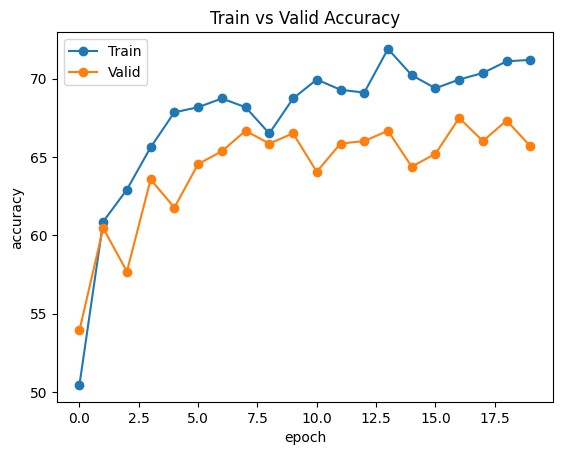

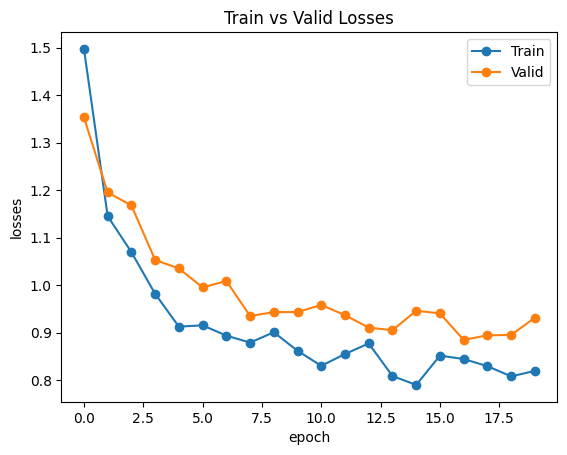

In [45]:
import os
import time
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import trange

EPOCHS = 20
PATIENCE = 10  # Number of epochs to wait before early stopping
BATCH_SIZE = 16
best_valid_loss = float('inf')
best_val_acc = 0.
epochs_no_improve = 0  # Counter for early stopping

# 1. **Count Parameters in AlexNet**
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_acc_gr = []
train_loss_gr = []
val_acc_gr = []
val_loss_gr = []

# 2. **Optimizing Learning Rate and Weight Decay**
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)

# 3. **Learning Rate Scheduler**
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# 4. **Fine-Tune Selected Layers (if using a pretrained AlexNet)**
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers initially

# Unfreeze specific layers for fine-tuning
for param in model.classifier.parameters():
    param.requires_grad = True

# Training Loop with Early Stopping
for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()

    # 5. **Training Step**
    train_loss, train_acc, train_acc_gr, train_loss_gr = train(model, train_loader, optimizer, criterion, device)
    
    # 6. **Validation Step**
    valid_loss, valid_acc, val_acc_gr, val_loss_gr = evaluate(model, val_loader, criterion, device)
    
    # Update scheduler based on validation loss
    scheduler.step(valid_loss)

    # Check for improvement
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_acc = valid_acc
        epochs_no_improve = 0  # Reset counter if validation improves
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve >= PATIENCE:
        print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss/accuracy.')
        break

    # Save model checkpoint every 30 epochs
    if epoch % 30 == 0:
        checkpoint_model(epoch, model, optimizer, best_val_acc, '/kaggle/working/CNN_epoch%d.pth' % epoch)

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Print metrics for each epoch
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Plot training and validation accuracy and loss
plt.plot(train_acc_gr, '-o')
plt.plot(val_acc_gr, '-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

plt.plot(train_loss_gr, '-o')
plt.plot(val_loss_gr, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses')
plt.show()


# **10. Testing the model**

In [46]:
epoch_loss = 0
epoch_acc = 0
image_preds_all = []
image_targets_all = []

model.eval()

with torch.no_grad():

    for (x, y) in tqdm(val_loader, desc="Evaluating", leave=False):

        x = x.to(device).float()
        y = y.to(device).long()

        y_pred = model(x)

        image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
        image_targets_all += [y.detach().cpu().numpy()]

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

image_preds_all = np.concatenate(image_preds_all)
image_targets_all = np.concatenate(image_targets_all)
score = (image_preds_all==image_targets_all).mean()

performance_matrix(image_targets_all, image_preds_all)

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Precision: 0.6278 Recall: 0.7243, Accuracy: 0.6569: ,f1_score: 0.6401
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84       113
           1       0.76      0.40      0.52       149
           2       0.42      0.85      0.56        40
           3       0.40      0.92      0.56        13
           4       0.63      0.56      0.59       122
           5       0.77      0.71      0.74        69
           6       0.68      0.66      0.67       106

    accuracy                           0.66       612
   macro avg       0.63      0.72      0.64       612
weighted avg       0.69      0.66      0.65       612



In [47]:
from PIL import Image

def predict_image(image_path, model, transform, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the same transformations as used during training
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the device (GPU/CPU)
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make prediction without calculating gradients
    with torch.no_grad():
        # Get the model's output
        output = model(image)

        # Get the predicted class
        _, predicted_class = torch.max(output, 1)

    # Return the predicted class
    return predicted_class.item()

# Example usage:
image_path = '/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment/Fungi/1692332350583.jpg'  # Replace with the path to the image you want to predict
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

predicted_class = predict_image(image_path, model, transform, device)
if predicted_class==0:
    print(f'The predicted class for the given image is: bacteria')
elif predicted_class==1:
    print(f'The predicted class for the given image is: fungi')
elif predicted_class==2:
    print(f'The predicted class for the given image is: healthy')
elif predicted_class==3:
    print(f'The predicted class for the given image is: Nemastode')
elif predicted_class==4:
    print(f'The predicted class for the given image is: k')
elif predicted_class==5:
    print(f'The predicted class for the given image is: Phytopthora')
elif predicted_class==6:
    print(f'The predicted class for the given image is: Virus')


The predicted class for the given image is: fungi
